<a href="https://colab.research.google.com/github/quangkhai5122/Dectection-Roof/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Đọc dữ liệu
Đọc ảnh images được lấy từ ảnh vệ tinh, các ảnh được lấy mẫu hầu hết ở các tỉnh ngoại thành, và một vài ảnh ở khu vực đông dân cư (dữ liệu được lấy từ https://earth.google.com/web).

Em có sử dụng các ứng dụng để vẽ được polygon mái nhà như `labelme` (file json) sau đó đọc ảnh bằng cv2 lưu các mái nhà dưới dạng ảnh nhị phân bitmask.

In [ ]:
!pip install segmentation_models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import imageio
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random
import segmentation_models as sm
import keras
from tensorflow.keras.optimizers import Adam
sm.set_framework('tf.keras')
from tensorflow.keras.callbacks import ModelCheckpoint
import segmentation_models as sm

# reading the data
project_path = "/content/drive/MyDrive/Colab Notebooks/"
images_path = os.path.join(project_path, "Data/images_vn/")
labels_path = os.path.join(project_path, "Data/labels_vn/")
images_list = sorted(os.listdir(images_path))
labels_list = sorted(os.listdir(labels_path))
images_dir_list = [images_path+i for i in images_list]
labels_dir_list = [labels_path+i for i in labels_list]

images = []
labels= []

for i in range(len(labels_dir_list)):
    img = imageio.imread(images_dir_list[i])
    bitMask = imageio.imread(labels_dir_list[i])
    bitMask = np.where(bitMask>0,1,0) # convert to binary mask
    images.append(img[:,:,:3]/255.) # remove the alpha channel
    labels.append(bitMask.reshape((256,256,1)))

images, labels = np.array(images), np.array(labels)

print(images_dir_list)
print(labels_dir_list)

Segmentation Models: using `keras` framework.


<ipython-input-3-11fb88994fe2>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(images_dir_list[i])
<ipython-input-3-11fb88994fe2>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bitMask = imageio.imread(labels_dir_list[i])


['/content/drive/MyDrive/Colab Notebooks/Data/images_vn/01.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/02.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/03.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/04.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/05.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/06.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/07.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/08.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/09.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/10.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/11.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/12.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/13.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/14.png', '/content/drive/MyDrive/Colab Notebooks/Data/images_vn/15.png', '/content/drive/MyDrive/Colab Notebooks

Vẽ biểu đồ dữ liệu bất kỳ.

/content/drive/MyDrive/Colab Notebooks/Data/images_vn/35.png /content/drive/MyDrive/Colab Notebooks/Data/labels_vn/35.png
34


Text(0.5, 1.0, 'Segmentation')

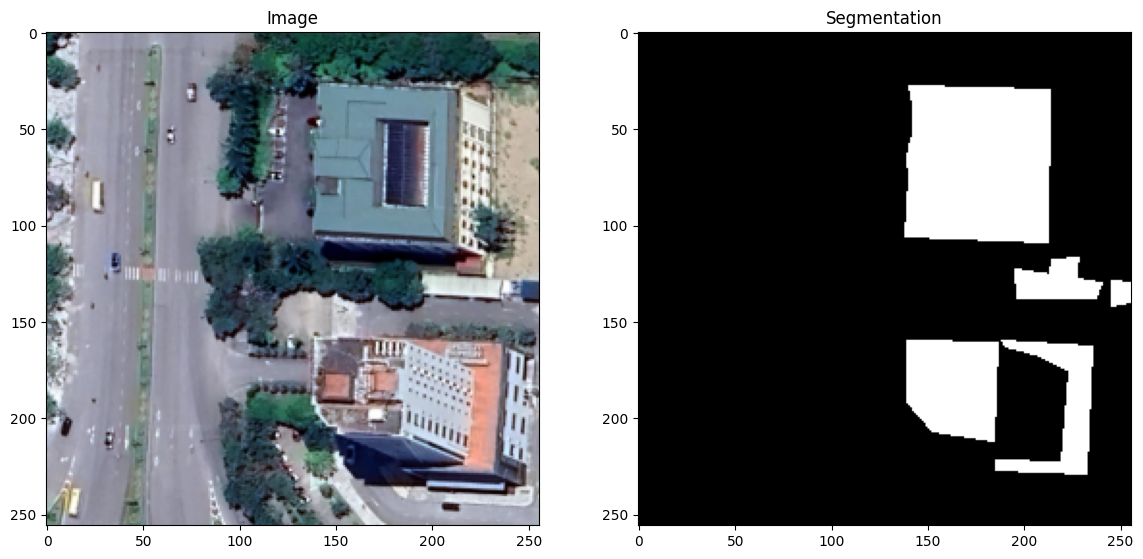

In [ ]:
i = np.random.randint(0, len(images_dir_list))
img, lbl = images[i], labels[i]
lbl = lbl.reshape((256,256,1))

print(images_dir_list[i], labels_dir_list[i])
print(i)

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(lbl, cmap='gray')
arr[1].set_title('Segmentation')

# Segmentation-models

Để thực hiện chuyển việc học cho mô hình phân đoạn, ở đây em sử dụng mô hình "segmentation_models" có sẵn trên https://segmentation-models.readthedocs.io/en/latest/tutorial.html. Tất cả các quá trình tiền xử lý và transfer learning đều được thực hiện tự động.

In [ ]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

# preprocess input to be consistent with the trained network
images_pro = preprocess_input1(images)


# test-train split
X_train, X_test, y_train, y_test = train_test_split(images_pro, labels, test_size = 0.2, random_state = 101)
print(X_train.shape)
print(X_test.shape)

(40, 256, 256, 3)
(10, 256, 256, 3)


# Data Augmentation

Mục đích:

- Tạo ra các phiên bản biến đổi của ảnh/mask gốc để:

- Tăng kích thước tập dữ liệu ảo

- Giúp mô hình học được tính bất biến (invariance) với các biến đổi hình học

- Chống overfitting

Ở đây chúng ta sử dụng 1 hàm để đảm bảo việc từng cặp ảnh sau khi augument được đồng bộ

In [ ]:
seed = 101

image_generate = ImageDataGenerator(
    rotation_range = 90,          # Xoay ngẫu nhiên 0-90 độ
    width_shift_range = 0.3,      # Dịch ngang 30% chiều rộng
    height_shift_range = 0.3,     # Dịch dọc 30% chiều cao
    shear_range = 0.5,            # Biến dạng trượt (shear)
    zoom_range = 0.3,             # Phóng to/thu nhỏ 30%
    horizontal_flip = True,       # Lật ngang
    vertical_flip = True,         # Lật dọc
    fill_mode = 'reflect'         # Cách điền pixel khi biến đổi
)

image_generate.fit(X_train, augment=True, seed=seed)

image_generator = image_generate.flow(X_train, seed=seed) # Tạo batch dữ liệu từ X_train

validate_img_generator = image_generate.flow(X_test, seed=seed) # Tạo batch dữ liệu từ X_test

label_generate = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.5,
    zoom_range = 0.3,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'reflect',
    preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

label_generate.fit(y_train, augment=True, seed=seed)

label_generator = label_generate.flow(y_train, seed=seed) # Tạo batch dữ liệu từ y_train

validate_lbl_generator = label_generate.flow(y_test, seed=seed) # Tạo batch dữ liệu từ y_test

def image_mask_generator(image_generator, label_generator):
    train_generator = zip(image_generator, label_generator) # Kết hợp 2 generator
    for (img, mask) in train_generator:
        yield (img, mask) # Trả về 1 tuple (img, mask) từ 2 generator

my_generator = image_mask_generator(image_generator, label_generator)
validation_data = image_mask_generator(validate_img_generator, validate_lbl_generator)

# Huấn luyện mô hình Segmentation sử dụng kiến trúc UNet với BACKBONE Resnet34

Đoạn code dưới đây định nghĩa và huấn luyện mô hình segmentation sử dụng kiến trúc U-Net với backbone là ResNet34 (được xác định trước đó qua biến BACKBONE)

Em sử dụng UNet là kiến trúc phổ biến cho bài toán segmentation, Backbone (resnet34): Mạng CNN làm encoder để trích xuất đặc trưng.

Hàm mất mát bce_jaccard_loss là kết hợp giữa Binary Cross-Entropy (BCE) và Jaccard Loss (IoU Loss):
$$\text{Loss} = \text{BCE} + (1 - \text{IoU})$$
Cho từng pixel, công thức BCE như sau:
$$
BCE = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right]
$$

- \( y_i \): Giá trị thực của pixel (0 hoặc 1).  
- \( p_i \): Xác suất dự đoán pixel thuộc lớp 1 (trong khoảng \([0,1]\)).  
- \( N \): Tổng số pixel.  
Công thức tính chỉ số IoU đo độ chính xác vùng chồng lấn:
$$
IoU = \frac{\text{Predicted Mask} \cap \text{Ground Truth}}{\text{Predicted Mask} \cup \text{Ground Truth}}
$$

- **Giá trị IoU nằm trong khoảng [0, 1]:**
  - **0**: Dự đoán hoàn toàn sai (không có sự chồng lắp).
  - **1**: Dự đoán trùng khớp hoàn hảo với Ground Truth.


In [ ]:
model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet'  # Sử dụng trọng số pretrained từ ImageNet
)
model.compile(
    optimizer='Adam',
    loss=sm.losses.bce_jaccard_loss,  # Kết hợp BCE và Jaccard Loss
    metrics=[sm.metrics.iou_score]    # Theo dõi IoU trong quá trình train
)

filepath_best_model = project_path + "best_roof_model.h5"

# Tạo callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=filepath_best_model,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
print(f"Model tốt nhất sẽ được lưu tại: {filepath_best_model}")

# print(model.summary())

# Training the model
history = model.fit(
    my_generator,
    validation_data=validation_data,
    steps_per_epoch = 50, # Số batch mỗi epoch (tập train)
    validation_steps = 50, # Số batch validation mỗi epoch
    epochs=80,
    callbacks=[checkpoint_callback]  # Thêm callback vào quá trình train
)

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model tốt nhất sẽ được lưu tại: /content/drive/MyDrive/Colab Notebooks/best_roof_model.h5
Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - iou_score: 0.3470 - loss: 1.1836
Epoch 1: val_iou_score improved from -inf to 0.18960, saving model to /content/drive/MyDrive/Colab Notebooks/best_roof_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - iou_score: 0.3488 - loss: 1.1790 - val_iou_score: 0.1896 - val_loss: 2.1441
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - iou_score: 0.5419 - loss: 0.8515
Epoch 2: val_iou_score did not improve from 0.18960
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 699ms/step - iou_score: 0.5427 - loss: 0.8487 - val_iou_score: 0.1116 - val_loss: 1.4206
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - iou_score: 0.5306 - loss: 0.9268
Epoch 3: val_iou_score did not improve from 0.18960
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 797ms/step - iou_score: 0.5320 - loss: 0.9227 - val_iou_score: 0.0737 - val_loss: 1.4817
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - iou_score: 0.6083 - loss: 0.6929
Epoch 4: val_iou_score did not improve from 0.18960
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 849ms/step - iou_score: 0.6088 - loss: 0.6918 - val_iou_score: 0.0151 - val_loss: 1.8550
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - iou_score: 0.6803 - loss: 0.5742
Epoch 5: val_iou_s

50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 776ms/step - iou_score: 0.3960 - loss: 1.3000 - val_iou_score: 0.2419 - val_loss: 1.0971
Epoch 22/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.6198 - loss: 0.5970
Epoch 22: val_iou_score improved from 0.24194 to 0.34398, saving model to /content/drive/MyDrive/Colab Notebooks/best_roof_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 924ms/step - iou_score: 0.6207 - loss: 0.5961 - val_iou_score: 0.3440 - val_loss: 1.1378
Epoch 23/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - iou_score: 0.6919 - loss: 0.5437
Epoch 23: val_iou_score did not improve from 0.34398
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 726ms/step - iou_score: 0.6915 - loss: 0.5449 - val_iou_score: 0.2195 - val_loss: 1.4341
Epoch 24/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - iou_score: 0.6060 - loss: 0.8060
Epoch 24: val_iou_score did not improve from 0.34398
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 632ms/step - iou_score: 0.6039 - loss: 0.8103 - val_iou_score: 0.1694 - val_loss: 1.5306
Epoch 25/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.3654 - loss: 1.2666
Epoch 25: val_iou_score did not improve from 0.34398
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 642ms/step - iou_score: 0.3640 - loss: 1.2679 - val_iou_score: 0.1602 - val_loss: 1.3984
Epoch 26/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - iou_score: 0.3336 - loss: 1.2536
Epoch 26:

50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 819ms/step - iou_score: 0.3332 - loss: 1.2537 - val_iou_score: 0.4662 - val_loss: 0.7599
Epoch 27/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - iou_score: 0.6123 - loss: 0.5845
Epoch 27: val_iou_score did not improve from 0.46620
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 685ms/step - iou_score: 0.6134 - loss: 0.5832 - val_iou_score: 0.1621 - val_loss: 1.9175
Epoch 28/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - iou_score: 0.3232 - loss: 1.4814
Epoch 28: val_iou_score did not improve from 0.46620
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 635ms/step - iou_score: 0.3224 - loss: 1.4799 - val_iou_score: 0.1710 - val_loss: 1.4171
Epoch 29/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - iou_score: 0.3015 - loss: 1.3294
Epoch 29: val_iou_score did not improve from 0.46620
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 652ms/step - iou_score: 0.3021 - loss: 1.3274 - val_iou_score: 0.1857 - val_loss: 1.4569
Epoch 30/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.2797 - loss: 1.4116
Epoch 30:

50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 842ms/step - iou_score: 0.3471 - loss: 1.4778 - val_iou_score: 0.5387 - val_loss: 0.6937
Epoch 45/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.3452 - loss: 1.3445
Epoch 45: val_iou_score did not improve from 0.53870
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 754ms/step - iou_score: 0.3481 - loss: 1.3362 - val_iou_score: 0.4431 - val_loss: 1.0145
Epoch 46/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - iou_score: 0.7028 - loss: 0.4567
Epoch 46: val_iou_score improved from 0.53870 to 0.62884, saving model to /content/drive/MyDrive/Colab Notebooks/best_roof_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 979ms/step - iou_score: 0.7032 - loss: 0.4563 - val_iou_score: 0.6288 - val_loss: 0.6096
Epoch 47/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.5410 - loss: 1.0797
Epoch 47: val_iou_score did not improve from 0.62884
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 686ms/step - iou_score: 0.5423 - loss: 1.0746 - val_iou_score: 0.1966 - val_loss: 1.6545
Epoch 48/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - iou_score: 0.7177 - loss: 0.5024
Epoch 48: val_iou_score did not improve from 0.62884
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 709ms/step - iou_score: 0.7151 - loss: 0.5106 - val_iou_score: 0.3200 - val_loss: 1.3700
Epoch 49/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - iou_score: 0.3955 - loss: 1.2502
Epoch 49: val_iou_score did not improve from 0.62884
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 629ms/step - iou_score: 0.3982 - loss: 1.2422 - val_iou_score: 0.1986 - val_loss: 1.6491
Epoch 50/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - iou_score: 0.3859 - loss: 1.3286
Epoch 50:

50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - iou_score: 0.3458 - loss: 1.3871 - val_iou_score: 0.6486 - val_loss: 0.5316
Epoch 54/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - iou_score: 0.6864 - loss: 0.5525
Epoch 54: val_iou_score did not improve from 0.64862
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 736ms/step - iou_score: 0.6868 - loss: 0.5515 - val_iou_score: 0.2559 - val_loss: 1.5959
Epoch 55/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - iou_score: 0.7647 - loss: 0.3901
Epoch 55: val_iou_score did not improve from 0.64862
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 687ms/step - iou_score: 0.7634 - loss: 0.3944 - val_iou_score: 0.6208 - val_loss: 0.6166
Epoch 56/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - iou_score: 0.3195 - loss: 1.5461
Epoch 56: val_iou_score did not improve from 0.64862
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 630ms/step - iou_score: 0.3225 - loss: 1.5359 - val_iou_score: 0.2057 - val_loss: 1.5674
Epoch 57/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - iou_score: 0.6892 - loss: 0.5420
Epoch 57: va

50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 962ms/step - iou_score: 0.7744 - loss: 0.4259 - val_iou_score: 0.6656 - val_loss: 0.5672
Epoch 62/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - iou_score: 0.7789 - loss: 0.4216
Epoch 62: val_iou_score did not improve from 0.66564
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 699ms/step - iou_score: 0.7789 - loss: 0.4214 - val_iou_score: 0.1797 - val_loss: 2.0214
Epoch 63/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.7790 - loss: 0.3996
Epoch 63: val_iou_score did not improve from 0.66564
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 633ms/step - iou_score: 0.7766 - loss: 0.4079 - val_iou_score: 0.2117 - val_loss: 1.6771
Epoch 64/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - iou_score: 0.3090 - loss: 1.5339
Epoch 64: val_iou_score did not improve from 0.66564
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 631ms/step - iou_score: 0.3099 - loss: 1.5296 - val_iou_score: 0.1873 - val_loss: 1.5776
Epoch 65/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - iou_score: 0.2923 - loss: 1.3200
Epoch 65:

Những vấn đề hiện tại
- Thời gian/epoch quá lâu (15p/epoch) -> Tăng batch_size hoặc đảm bảo GPU
- Validation loss tăng -> Thử giảm learning rate (đang mặc định là 1e-3)
- Overfitting (IoU train cao nhưng val thấp) -> Thêm Regularizationv, augmentation mạnh hơn, Early Stopping


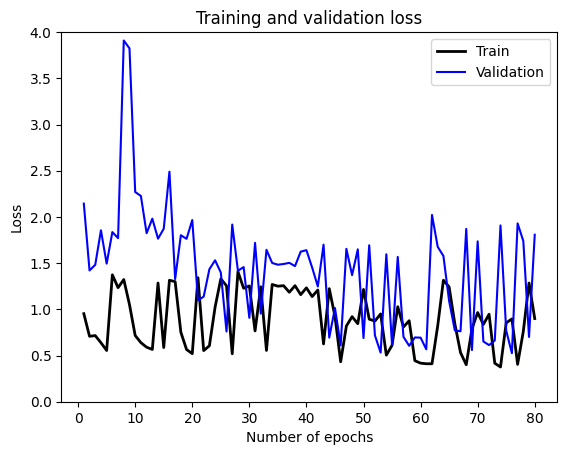

In [ ]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
number_epochs = range(1, len(train_loss) + 1)

plt.plot(number_epochs, train_loss, 'k', lw=2, label='Train')
plt.plot(number_epochs, validation_loss, 'b', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.legend()
plt.show()

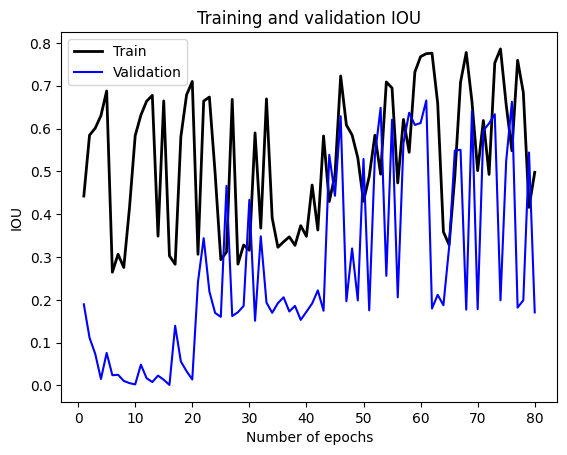

In [ ]:
iou_score = history.history['iou_score']
validation_iou_score = history.history['val_iou_score']

plt.plot(number_epochs, iou_score, 'k', lw=2, label='Train')
plt.plot(number_epochs, validation_iou_score, 'b', label='Validation')
plt.title('Training and validation IOU')
plt.xlabel('Number of epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
IoU socre is:  0.7190381861752246
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


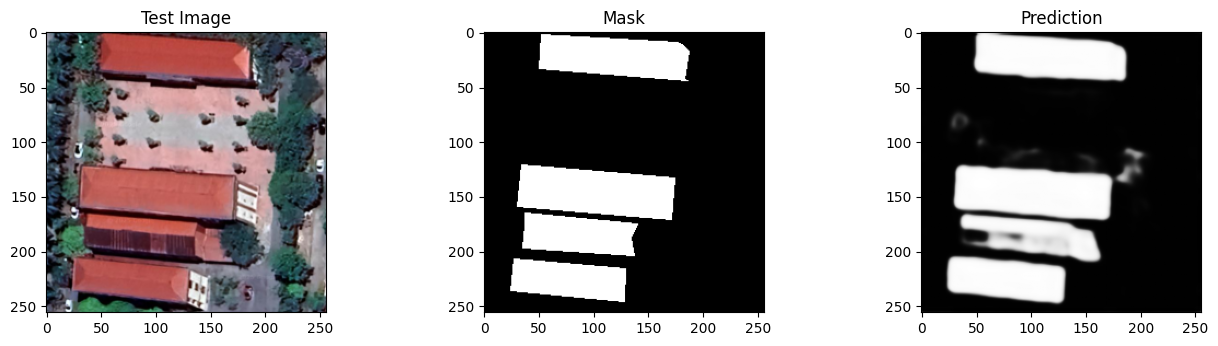

<Figure size 640x480 with 0 Axes>

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

N = random.randint(0, len(X_test)-1)
prediction = model.predict(np.expand_dims(X_test[N],0))


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Test Image')
plt.imshow(X_test[N])
plt.subplot(232)
plt.title('Mask')
plt.imshow(y_test[N], cmap='gray')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction[0], cmap='gray')

plt.show()

plt.savefig("test.pdf")

những ảnh có nhiều cây vướng vào mái:
06, 16, 18, 26, 27, 28, 32, 37, 38, 39, 40, 42, 44, 47,
nhiều mái
09, 10, 20, 21, 24, 29, 34, 41, 43, 46, 49, 50.